# `BUILDING A ML MODEL TO PREDICT CUSTOMER CHURN` 
#### Using the CRISP-DM framework

## `Business Understanding`


#### Goal/Description
To create a machine learning model to predict the likelihood of retaining a customer

#### `Null Hypothesis`
There is no relationship between a tech savy customer and the customer retention

#### `Alternate Hypothesis`
There is a relationship between a tech savy customer and the customer retention

#### `Analytical Questions`
- How does tenure and monthly charge affect customer churn?
- What is the likelihood of a customer with online security and protection to churn?
- What is the relationship between the type of contract and the likelihood of a customer churn?
- Do customers with dependents and internet security likely to Churn?

## `Data Understanding`

#### Data Source
The data was sourced from a Telecommunication company and divided into three (3) parts :
- 3000 rows as the training data
- 2000 rows as the evaluation data 
- 2000 rows as the test data 

### `Issues`
- Some columns have multiple adjectives of the same word. eg no,no internet service,false 


#### Data Exploration

##### `Libraries`

In [207]:
#Libraries imported
import sqlalchemy as sa
import pyodbc  
from dotenv import dotenv_values 
import pandas as pd
from scipy import stats 
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import collections
import numpy as np

###FILTER WARNINGS

from sklearn.model_selection import * #train_test_split, cross_val_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.metrics import *
from sklearn.model_selection import * 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


##### `Database Connection`

In [208]:
#Access protocols for the SQL Database
env_variables= dotenv_values('logins.env')
database= env_variables.get('database')
server = env_variables.get('server')
username = env_variables.get('username')
password = env_variables.get('password')

Python-dotenv could not parse statement starting at line 5


In [209]:
#Creation of Connection to Database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"
connection = pyodbc.connect(connection_string)

In [210]:
#Querying SQL Database and reading the table into a dataframe
query = "SELECT * FROM LP2_Telco_churn_first_3000"

sql_df= pd.read_sql(query, connection)
sql_df.info()

C:\Users\chrap\AppData\Local\Temp\ipykernel_23836\2011694408.py:4: UserWarning:

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        3000 non-null   object 
 1   gender            3000 non-null   object 
 2   SeniorCitizen     3000 non-null   bool   
 3   Partner           3000 non-null   bool   
 4   Dependents        3000 non-null   bool   
 5   tenure            3000 non-null   int64  
 6   PhoneService      3000 non-null   bool   
 7   MultipleLines     2731 non-null   object 
 8   InternetService   3000 non-null   object 
 9   OnlineSecurity    2349 non-null   object 
 10  OnlineBackup      2349 non-null   object 
 11  DeviceProtection  2349 non-null   object 
 12  TechSupport       2349 non-null   object 
 13  StreamingTV       2349 non-null   object 
 14  StreamingMovies   2349 non-null   object 
 15  Contract          3000 non-null   object 
 16  PaperlessBilling  3000 non-null   bool   


In [211]:
# Describing the SQL Dataframe
sql_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,3000,3000,7590-VHVEG,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,3000,2,Male,1537,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,3000,2,False,2525,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Partner,3000,2,False,1538,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,3000,2,False,2070,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,3000.0,NaN,NaN,NaN,32.527333,24.637768,0.0,9.0,29.0,56.0,72.0
PhoneService,3000,2,True,2731,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2731,2,False,1437,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,3000,3,Fiber optic,1343,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2349,2,False,1478,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### `Accessing the second set of data in CSV format`

In [212]:
##Accessing the second set of data 
csv_df = pd.read_csv("data\\LP2_Telco-churn-second-2000.csv")
csv_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2043 entries, 0 to 2042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2043 non-null   object 
 1   gender            2043 non-null   object 
 2   SeniorCitizen     2043 non-null   int64  
 3   Partner           2043 non-null   object 
 4   Dependents        2043 non-null   object 
 5   tenure            2043 non-null   int64  
 6   PhoneService      2043 non-null   object 
 7   MultipleLines     2043 non-null   object 
 8   InternetService   2043 non-null   object 
 9   OnlineSecurity    2043 non-null   object 
 10  OnlineBackup      2043 non-null   object 
 11  DeviceProtection  2043 non-null   object 
 12  TechSupport       2043 non-null   object 
 13  StreamingTV       2043 non-null   object 
 14  StreamingMovies   2043 non-null   object 
 15  Contract          2043 non-null   object 
 16  PaperlessBilling  2043 non-null   object 


In [213]:
# Describing the Dataframe
csv_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,2043,2043,5600-PDUJF,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,2043,2,Male,1022,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,2043.0,NaN,NaN,NaN,0.16838,0.374295,0.0,0.0,0.0,0.0,1.0
Partner,2043,2,No,1047,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,2043,2,No,1412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,2043.0,NaN,NaN,NaN,32.649046,24.376248,0.0,9.0,30.0,55.0,72.0
PhoneService,2043,2,Yes,1823,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,2043,3,No,987,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,2043,3,Fiber optic,905,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,2043,3,No,1029,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### `Merging the Two Dataframes`

In [214]:
com_df=pd.concat([sql_df,csv_df],ignore_index=True)
com_df.head(5)
com_df.shape

(5043, 21)

In [215]:
#Checking the datatypes of the columns
datatypes = com_df.dtypes
datatypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

##### Converting the TotalCharges datatype to float64

In [216]:
#Converting TotalCharges column to numeric
com_df['TotalCharges'] = pd.to_numeric(com_df['TotalCharges'], errors='coerce')
com_df=com_df.reset_index()

In [217]:
# Checking the Null value
com_df.isnull().sum()

index                 0
customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 1
dtype: int64

In [218]:
com_df.head(5)

,index,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [219]:
#Dropping the index column
com_df = com_df.drop(['index'], axis=1)

##### Replacing all negatives with False and positives with True

In [220]:
com_df.replace(['No','No internet service','false','No phone service'], "False", inplace=True)

com_df.replace('Yes',"True", inplace=True)



In [221]:
com_df['SeniorCitizen'] = np.where(com_df['SeniorCitizen'] == 1, True, False)


In [222]:
com_df.InternetService.replace('false','None')

0               DSL
1               DSL
2               DSL
3               DSL
4       Fiber optic
           ...     
5038            DSL
5039    Fiber optic
5040            DSL
5041    Fiber optic
5042    Fiber optic
Name: InternetService, Length: 5043, dtype: object

In [223]:
datatypes = com_df.dtypes
datatypes

customerID           object
gender               object
SeniorCitizen          bool
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

##### Making the True/False to Boolean

In [224]:
com_df.replace({'True': True, 'False': False}, inplace=True)

C:\Users\chrap\AppData\Local\Temp\ipykernel_23836\739084101.py:1: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



### Univariate Analysis

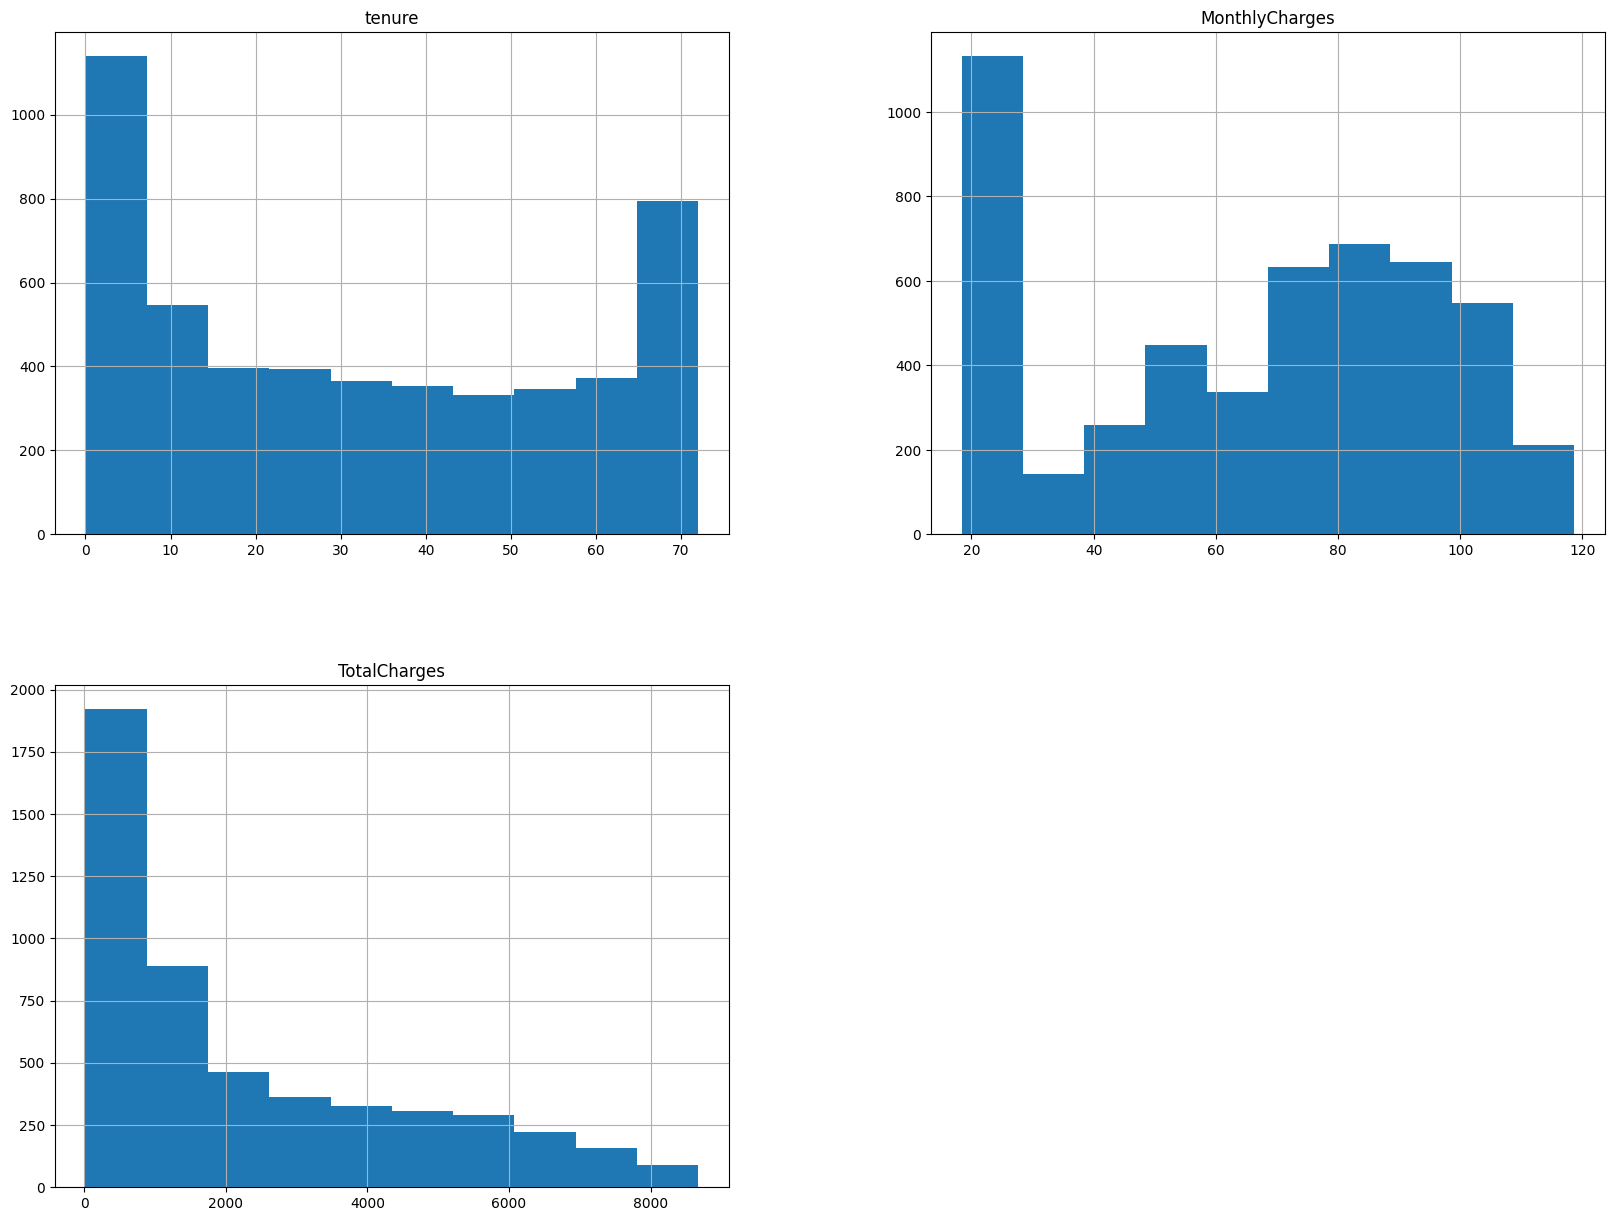

In [225]:
# Distribution of the variables
com_df.hist(figsize=(20, 15))
plt.show()

In [226]:
# Visualize the distribution of categorical columns
categoricals = [column for column in com_df.columns if com_df[column].dtype == "O"]
for column in categoricals:
        if column not in ['customerID']:
                fig = px.histogram(com_df, x=com_df[column], text_auto=True,color=column,
                               title=f"Distribution of customers based on {column}")
               
                fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-45)
                fig.show()


#### OBSERVATION
- The Gender is evenly distributed 
- Over 50% of all contract types are month-on-month basis
- Electronic Check is the most used,covering 30% of all payment methods


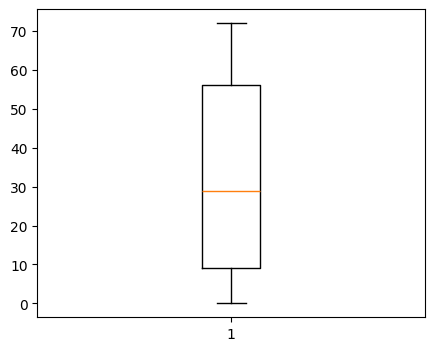

In [227]:
fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.boxplot(com_df.tenure)
plt.show()

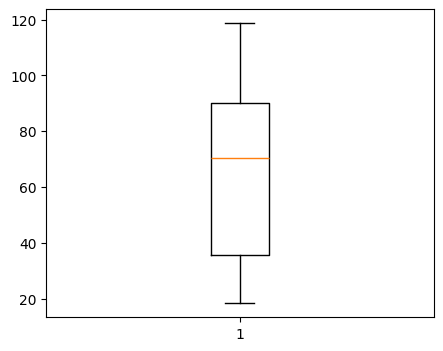

In [228]:
fig = plt.figure(figsize =(5, 4))
 
# Creating plot
plt.boxplot(com_df.MonthlyCharges)
plt.show()

### Bivariate Analysis

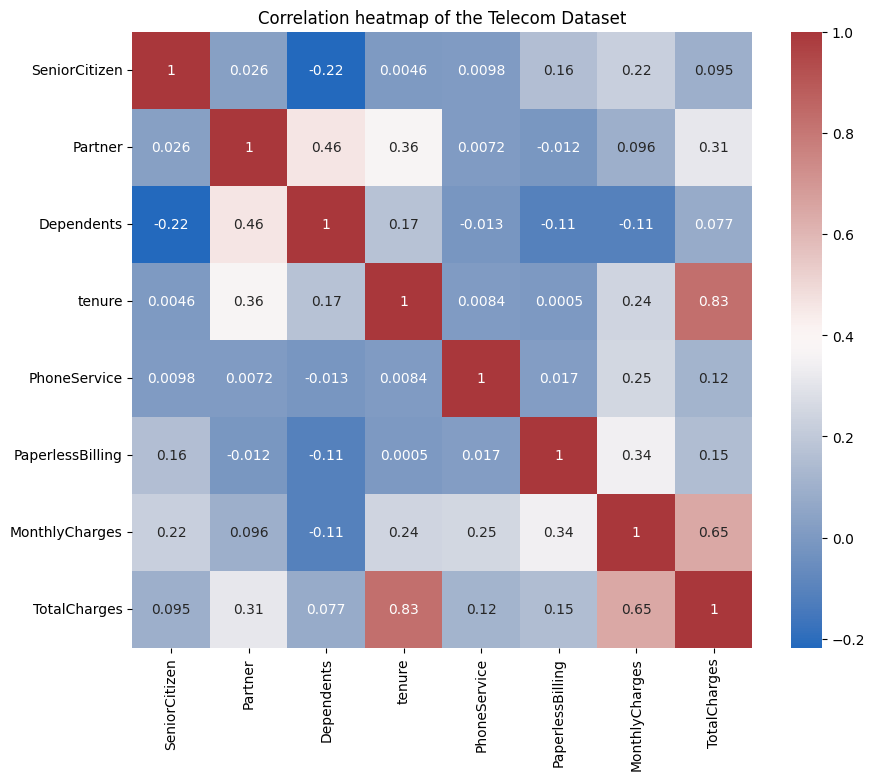

In [229]:
# Summarizing the relationships between the variables with a heatmap of the correlations
correlation_matrix = com_df.corr(numeric_only= True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag')
plt.title("Correlation heatmap of the Telecom Dataset")
plt.show()

 ## `Answering the Analytical Questions`


##### `How does tenure and monthly charge affect customer churn?`


C:\Users\chrap\AppData\Local\Temp\ipykernel_23836\2474029954.py:5: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='tenure Group,Churn'>

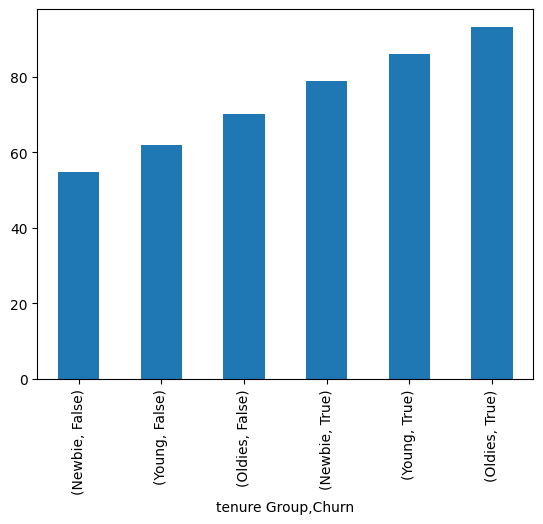

In [230]:

bins = [ 10, 30, 50,70]
df=com_df
labels = ['Newbie', 'Young', 'Oldies']
df['tenure Group'] = pd.cut(df['tenure'], bins=bins, labels=labels)
streamers = com_df.groupby(['tenure Group','Churn'])['MonthlyCharges'].mean().sort_values(ascending=True)
streamers.plot(kind='bar')

#### OBSERVATION
- New,Existing and Old Customers with higher charges for software usage are the ones churning.
- There has to be a loyalty promotion for old customers to lock in the old customers.
- There can also be a signup discount to new customers to lock them in on the software.

##### `What is the likelihood of a customer with online security and device protection to churn?`


<Axes: xlabel='OnlineSecurity,DeviceProtection'>

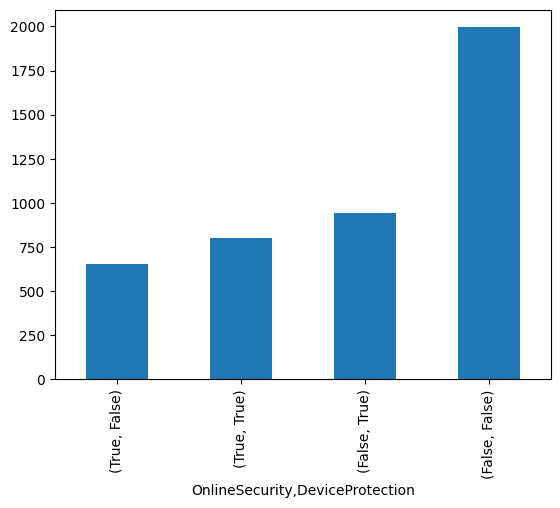

In [231]:
cust_retention = com_df.groupby(['OnlineSecurity','DeviceProtection'])['Churn'].count().sort_values(ascending=True)
cust_retention.plot(kind='bar')

#### OBSERVATION
- Customers with no security at all are more likely to Churn. 
- Basic cybersecurity can be done to curb customer doubt to reduce Churn.

#### `What is the relationship between the type of contract and the likelihood of a customer churn?`


<Axes: xlabel='Contract'>

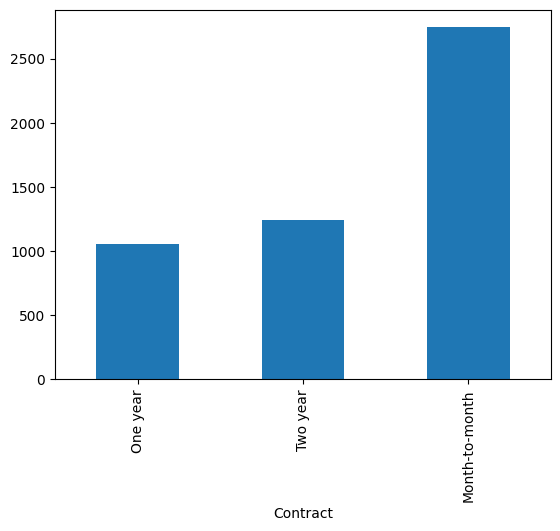

In [232]:
cust_contract = com_df.groupby('Contract')['Churn'].count().sort_values(ascending=True)
cust_contract.plot(kind='bar')

#### OBSERVATION
- Month-to-Month Customers are more likely to churn as they are likely to be floating users.

#### `Do customers with dependents and internet security likely to Churn?`

<Axes: xlabel='OnlineSecurity,Dependents'>

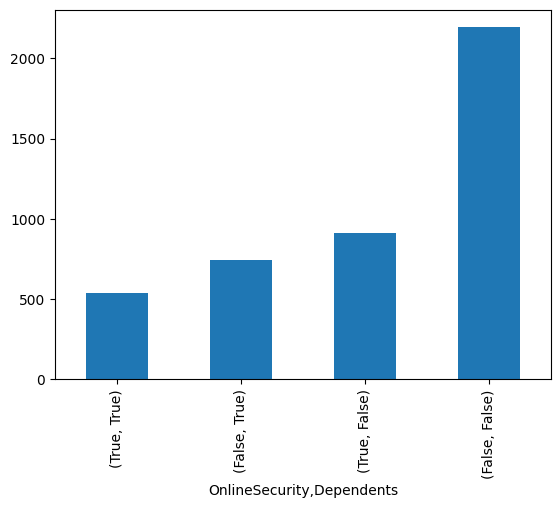

In [233]:
cust_contract = com_df.groupby(['OnlineSecurity','Dependents'])['Churn'].count().sort_values(ascending=True)
cust_contract.plot(kind='bar')

#### OBSERVATION
Customers with both Online Security and Dependents are less likely to churn.

In [234]:
com_df.isnull().sum()


customerID             0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
tenure                 0
PhoneService           0
MultipleLines        269
InternetService        0
OnlineSecurity       651
OnlineBackup         651
DeviceProtection     651
TechSupport          651
StreamingTV          651
StreamingMovies      651
Contract               0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           8
Churn                  1
tenure Group        1764
dtype: int64

In [235]:
#Dropping Empty rows
com_df = com_df.dropna(subset=['OnlineSecurity','OnlineBackup','DeviceProtection','MultipleLines','TotalCharges','Churn'],axis=0)

In [236]:
#finding duplicates
duplicate = com_df[com_df.duplicated()]
duplicate.shape

(0, 22)

##### OBSERVATION 
No duplicates found

#### `HYPOTHESIS`

In [278]:
#Checking Normality of the data 

def check_normality(data,name):
    test_stat_normality, p_value_normality=stats.shapiro(data)
    print("p value:%.20f" % p_value_normality)
    if p_value_normality <0.05:
        print(f"Reject null hypothesis >> The data for {name} is not normally distributed")
    else:
        print(f"Fail to reject null hypothesis >> The data for {name} is normally distributed")

In [279]:
#Hypothesis

df_tech= com_df.loc[com_df.OnlineSecurity & com_df.DeviceProtection]
online=com_df.loc[com_df.OnlineSecurity]
device= com_df.loc[com_df.DeviceProtection]


In [280]:
#Normality Checks
check_normality(df_tech.TotalCharges,'Online Security and Device Protection')
check_normality(online.TotalCharges,'Online Security')
check_normality(device.TotalCharges,'Device Protection')

p value:0.00000000001746254682
Reject null hypothesis >> The data for Online Security and Device Protection is not normally distributed
p value:0.00000000000000000142
Reject null hypothesis >> The data for Online Security is not normally distributed
p value:0.00000000000000000001
Reject null hypothesis >> The data for Device Protection is not normally distributed


In [281]:
#Using the P-Levene to test the Hypothesis
stat, pvalue_levene= stats.levene(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges )

print("p value:%.10f" % pvalue_levene)
if pvalue_levene <0.05:
    print("Reject null hypothesis >> The variances of the samples are different.")
else:
    print("Fail to reject null hypothesis >> The variances of the samples are same.")

p value:0.0001300041
Reject null hypothesis >> The variances of the samples are different.


##### Observation 
- Data samples are not normally distributed
- The variances of the samples are different
- Therefore a Non-Parametric test must be done (Kruskal Test)

In [282]:
#Kruskal Test

stat, p = kruskal(df_tech.TotalCharges, online.TotalCharges,device.TotalCharges)
print('Statistics=%.3f, p=%.15f' % (stat, p))

if p > 0.05:
 print('All sample distributions are the same (fail to reject H0)')
else:
 print('One or more sample distributions are not equal distributions (reject null Hypothesis)')

Statistics=84.496, p=0.000000000000000
One or more sample distributions are not equal distributions (reject null Hypothesis)


##### OBSERVATION
Reject the null Hypothesis

### `Data preparation`

#### Feature Correlation and Selection

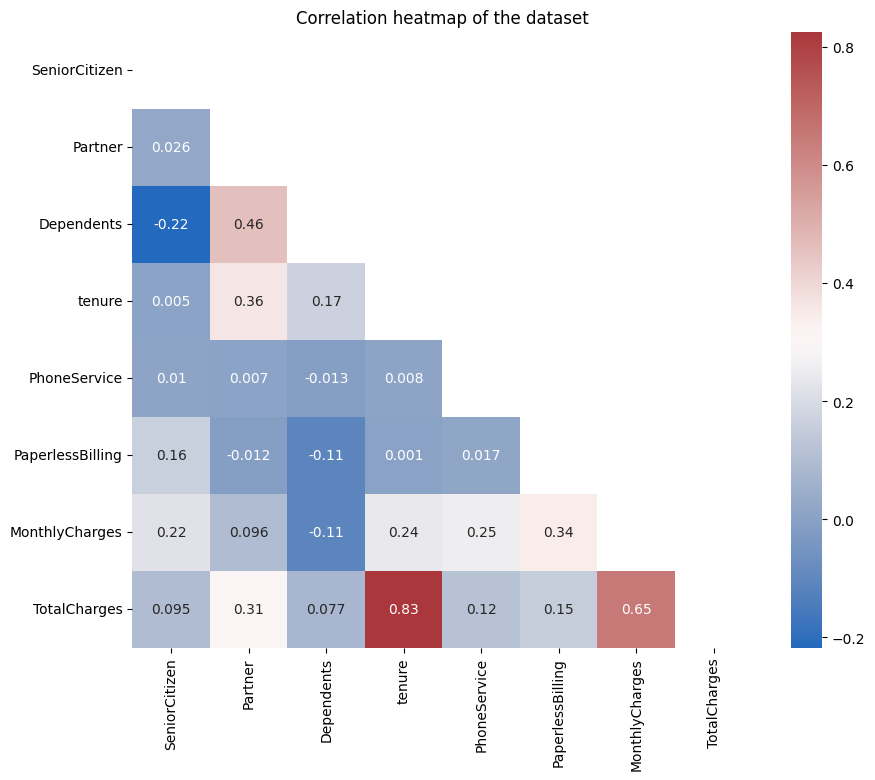

In [242]:
# Summarize the relationships between the variables with a heatmap of the correlations
correlation_matrix = df.corr(numeric_only= True).round(3)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True,cmap='vlag',mask=mask)
plt.title("Correlation heatmap of the dataset")
plt.show()

In [243]:
df =com_df.drop(columns=['customerID','gender','TotalCharges','tenure Group'],axis=1)
df.head(1)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
1,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,False


In [244]:
# Dropping row with null value
df.dropna(axis=0, inplace=True)

In [245]:
df.replace({True: 'Yes', False: 'No'})

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
1,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,No
2,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,Yes
4,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,Yes
5,No,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.650002,Yes
6,No,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.099998,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5038,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.800000,No
5039,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.200000,No
5040,No,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.600000,No
5041,Yes,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.400000,Yes


### Convert booleans to string rather

## Boolean Function to convert True/False string to boolean
def boolean_(df):
    cols= df.columns.tolist()

    for col in cols:
        unique=df[col].unique().tolist()
        if len(unique)==2:
            df[col]=df[col].astype(bool)
            print(col,unique)
    return df


In [246]:
df.dtypes

SeniorCitizen          bool
Partner                bool
Dependents             bool
tenure                int64
PhoneService           bool
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling       bool
PaymentMethod        object
MonthlyCharges      float64
Churn                object
dtype: object

In [247]:
df["PaperlessBilling"].unique().tolist()
df["PaperlessBilling"]=df["PaperlessBilling"].replace({True: 'True', False: 'False'})


In [248]:
df["PhoneService"].unique().tolist()
df["PhoneService"]=df["PhoneService"].replace({True: 'True', False: 'False'})

In [249]:
df["SeniorCitizen"].unique().tolist()
df["SeniorCitizen"]=df["SeniorCitizen"].replace({True: 'True', False: 'False'})

In [250]:
df["Partner"].unique().tolist()
df["Partner"]=df["Partner"].replace({True: 'True', False: 'False'})

In [251]:
df["Dependents"].unique().tolist()
df["Dependents"]=df["Dependents"].replace({True: 'True', False: 'False'})

In [252]:
df["InternetService"].unique().tolist()
df["InternetService"]=df["InternetService"].replace({False: 'False'})

In [253]:
df["Churn"].unique().tolist()
df["Churn"]=df["Churn"].replace({True: '1', False: '0'})

df.replace("False", "No", inplace=True)

df.replace( "True",'Yes' , inplace=True)

In [254]:
df.dtypes

SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
Churn                object
dtype: object

df["InternetService"].replace("False", "No", inplace=True)
df["InternetService"].astype(str)
df["InternetService"].unique().tolist()

In [255]:
df.head(3)

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
1,False,False,False,34,True,False,DSL,True,False,True,False,False,False,One year,False,Mailed check,56.950001,0
2,False,False,False,2,True,False,DSL,True,True,False,False,False,False,Month-to-month,True,Mailed check,53.849998,1
4,False,False,False,2,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,70.699997,1


df['Churn'] = df['Churn'].astype(int)

In [283]:
# Looking at the descriptive statistics of the columns with categorical values
cats = [column for column in df.columns if (df[column].dtype == "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
df[cats].describe(include="all")


Summary table of the Descriptive Statistics of Columns with Numeric Values


,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
count,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118,4118
unique,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4,2
top,False,False,False,True,False,Fiber optic,False,False,False,False,False,False,Month-to-month,True,Electronic check,0
freq,3354,2105,2927,3898,2148,2247,2781,2507,2491,2745,2285,2263,2381,2649,1543,2886


In [284]:
# Looking at the descriptive statistics of the columns with numeric values
numerics = [column for column in df.columns if (df[column].dtype != "O")]
print("Summary table of the Descriptive Statistics of Columns with Numeric Values")
df[numerics].describe()


Summary table of the Descriptive Statistics of Columns with Numeric Values


,tenure,MonthlyCharges
count,4118.000000,4118.000000
mean,32.853813,73.520435
std,24.534154,26.210337
min,1.000000,18.550000
25%,9.000000,55.762500
50%,30.000000,78.950000
75%,56.000000,94.199997
max,72.000000,118.650002


In [258]:
# Create a boolean mask to identify boolean columns
boolean_mask = df.dtypes == bool

# Select columns with boolean values
boolean_columns = df.columns[boolean_mask]

# Display the selected columns
boolean_columns


Index([], dtype='object')

#### `Modeling`

def str_(df):
    cols= df.columns.tolist()

    for col in cols:
        unique=df[col].unique().tolist()
        if len(unique)==2:
            df[col]= df[col].astype(str)
            print(col,unique)
    return df

df=str_(df)

In [259]:
cats=df.select_dtypes('object').columns


In [260]:
numerics = df.select_dtypes('number').columns

In [261]:
numerics

Index(['tenure', 'MonthlyCharges'], dtype='object')

In [262]:
cats

Index(['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [263]:
df.dtypes

SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
Churn                object
dtype: object

In [285]:
cols= df.columns.tolist()
for col in cols:
        unique=df[col].unique().tolist()
        print(col,unique)

SeniorCitizen ['False', 'True']
Partner ['False', 'True']
Dependents ['False', 'True']
tenure [34, 2, 8, 22, 28, 62, 13, 58, 49, 25, 69, 71, 10, 21, 30, 47, 72, 17, 27, 1, 5, 46, 11, 70, 63, 52, 43, 15, 60, 18, 66, 9, 3, 31, 64, 56, 7, 42, 35, 65, 12, 38, 68, 55, 37, 33, 67, 23, 61, 14, 16, 20, 53, 4, 40, 6, 59, 44, 19, 54, 50, 41, 51, 32, 57, 45, 24, 29, 48, 36, 39, 26]
PhoneService ['True', 'False']
MultipleLines [False, True]
InternetService ['DSL', 'Fiber optic', 'False']
OnlineSecurity [True, False]
OnlineBackup [False, True]
DeviceProtection [True, False]
TechSupport [False, True]
StreamingTV [False, True]
StreamingMovies [False, True]
Contract ['One year', 'Month-to-month', 'Two year']
PaperlessBilling ['False', 'True']
PaymentMethod ['Mailed check', 'Electronic check', 'Credit card (automatic)', 'Bank transfer (automatic)']
MonthlyCharges [56.95000076293945, 53.849998474121094, 70.69999694824219, 99.6500015258789, 89.0999984741211, 104.80000305175781, 56.150001525878906, 49.950

In [265]:
X=df.drop(columns=['Churn'],axis=1)
y=df['Churn']

In [266]:
for column in X.select_dtypes('object'):
    print(column)

SeniorCitizen
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod


In [267]:
X.columns

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges'],
      dtype='object')

In [268]:
X.dtypes

SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
dtype: object

def str_(df):
    cols= df.columns.tolist()

    for col in cols:
        unique=df[col].unique().tolist()
        if len(unique)==2:
            df[col]= df[col].astype(str)
            print(col,unique)
    return df

X=str_(X)

In [269]:
cats=X.select_dtypes('object').columns

In [270]:
cats

Index(['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=27)

In [287]:
y_test

1314    1
3610    1
3248    0
3380    1
1604    0
       ..
3934    1
1211    1
1403    0
1305    0
3109    0
Name: Churn, Length: 2059, dtype: object

In [273]:
# making pipeline
scaler = StandardScaler()
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
# putting numeric columns to scaler and categorical to encoder
num_transformer = Pipeline(steps=[
    ('num', scaler)
])
cat_transformer = Pipeline(steps=[
    ('cat', encoder)
])



In [274]:
# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer , numerics),
                    ('cat', cat_transformer , cats)])

In [288]:
## XGBoost Classifier
log_mod = Pipeline(steps=[("preprocessor", preprocessor), 
                          ("model", CatBoostClassifier(random_state=27, verbose = False))])


log_mod.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  Index(['tenure', 'MonthlyCharges'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object'))])),
                ('model',
                 <catboost.core.CatBoostClassifier object at 0x000001C241097B50>)])

In [290]:
# Predict on the test data
log_mod_pred = log_mod.predict(X_test)
log_mod_pred

array(['0', '1', '0', ..., '0', '0', '0'], dtype=object)

In [291]:
# Evaluate the model
xgb_clf_report = classification_report(y_test, log_mod_pred)
print(xgb_clf_report)

              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1445
           1       0.64      0.54      0.59       614

    accuracy                           0.77      2059
   macro avg       0.73      0.70      0.71      2059
weighted avg       0.76      0.77      0.77      2059



In [293]:
# Confusion Matrix
xgb_clf_conf_mat = confusion_matrix(y_test, log_mod_pred)
xgb_clf_conf_mat


array([[1256,  189],
       [ 282,  332]], dtype=int64)

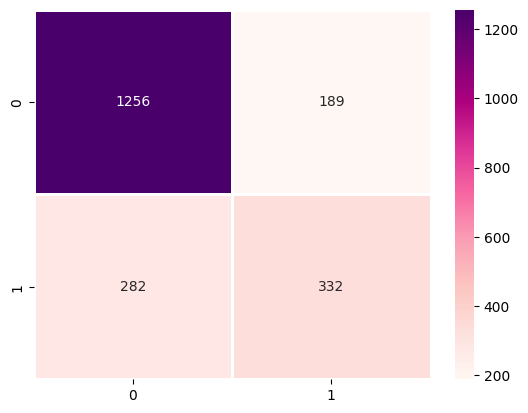

In [294]:
# Visualizing the Confusion Matrix
f, ax = plt.subplots()
sns.heatmap(xgb_clf_conf_mat, annot=True, linewidth=1.0, fmt=".0f", cmap="RdPu", ax=ax)
plt.show()

Done
Done